In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate

from astropy.cosmology import FlatLambdaCDM
import GPy
import sys
sys.path.append('../code')
from photoz_kernels import *

cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=None)
DL = cosmo.luminosity_distance

In [2]:
max_redshift = 2.0
ab_filters = ['u', 'g', 'r', 'i', 'z']
numBands = len(ab_filters)
amp_arr = np.genfromtxt('filter_gaussian_coefficients_amp_'+''.join(ab_filters)+'.txt')
mu_arr = np.genfromtxt('filter_gaussian_coefficients_mu_'+''.join(ab_filters)+'.txt')
sig_arr = np.genfromtxt('filter_gaussian_coefficients_sig_'+''.join(ab_filters)+'.txt')
numCoefs = amp_arr.shape[0]

f_mod = np.load('CWW_redshiftgrid_zmax'+str(max_redshift)+''.join(ab_filters)+'.npy')
f_mod2 = np.load('CWW_redshiftgrid_zmax'+str(max_redshift)+''.join(ab_filters)+'_nolines.npy')
nz, nt, nf = f_mod.shape
redshiftGrid = np.linspace(0, max_redshift, num=nz)
f_mod_interps = np.zeros((nt, nf), dtype=object)
f_mod_interps2 = np.zeros((nt, nf), dtype=object)
for jf in range(nf):                            
    for it in range(nt):
        f_mod_interps[it, jf] = scipy.interpolate.interp1d(redshiftGrid, f_mod[:,it,jf], kind='cubic')
        f_mod_interps2[it, jf] = scipy.interpolate.interp1d(redshiftGrid, f_mod2[:,it,jf], kind='cubic')
        
lines_mu = np.array([ 3732.22, 5002.26, 1392.07, 1542.91, 2009.82, 2384.11, 2795.42, 
                     3174.70, 4858.05, 5401.32, 6292.06, 6556.74, 6719.12, 8775.69, 
                     3253.81, 3372.75, 3528.47, 3870.62, 4104.03, 4343.24, 5308.43, 
                     6853.21, 7027.87, 7134.49, 7227.85, 9065.54, 9230.14, 9527.33, 
                     9603.17, 1213.04, 3835.44, 3969.87 ])
lines_sig = np.array([ 23.11, 34.10, 6.41, 5.58, 22.81, 2.63, 11.14, 3.90, 3.68, 
                      11.83, 3.18, 4.39, 10.70, 6.77, 5.33, 2.14, 4.74, 9.18, 
                      7.03, 8.57, 4.43, 2.49, 11.83, 3.84, 3.13, 4.99, 4.52, 
                      5.01, 5.04, 8.20, 2.46, 2.93 ])
print lines_mu.size, lines_sig.size

32 32


In [3]:
numObjectsPerType = 3
bandsUsed = range(5) # [0, 4] #
numBandsUsed = len(bandsUsed)
typesUsed = np.arange(nt)#np.arange(3)#
numpoints = numObjectsPerType*typesUsed.size
#redshifts = np.random.uniform(low=0, high=max_redshift, size=numpoints)
if numObjectsPerType == 1:
    redshifts = np.ones((typesUsed.size,))
else:
    redshifts = np.outer(np.linspace(0, max_redshift, num=numObjectsPerType), np.ones(typesUsed.size)).T.flatten()
types = np.outer(np.ones(numObjectsPerType), typesUsed).T.flatten()

nd = numBandsUsed*numpoints
X = np.zeros((nd, 3))
Ytruth = np.zeros((nd, ))
Ynoise = np.zeros((nd, ))
Y = np.zeros((nd, ))
off = 0
Ynoisevarianceval = 0.02**2
for ip in range(numpoints):
    for jf in bandsUsed:
        X[off, 0] = types[ip]
        X[off, 1] = jf
        X[off, 2] = redshifts[ip]
        Ytruth[off] = f_mod_interps[types[ip], jf](redshifts[ip])
        Ynoise[off] = Ynoisevarianceval
        Y[off] = Ytruth[off] + np.sqrt(Ynoise[off]) * np.random.randn()
        off += 1

 /Users/bl/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: VisibleDeprecationWarning:using a non-integer number instead of an integer will result in an error in the future


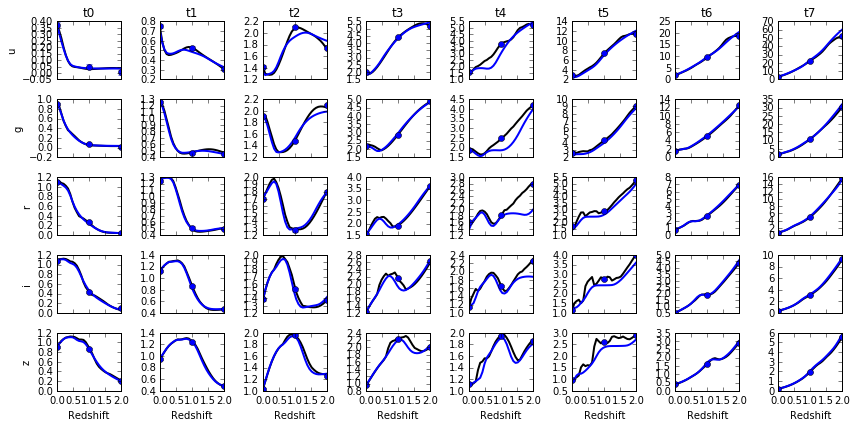

In [4]:
fig, axs = plt.subplots(nf, nt, figsize=(12, 6), sharex=True, sharey=False)
for bi in range(nf):
    for t in range(nt):
        axs[bi,t].plot(redshiftGrid, f_mod[:,t,bi], ls='solid', c='k', lw=2)
        axs[bi,t].plot(redshiftGrid, f_mod2[:,t,bi], ls='solid', c='b', lw=2)
        ind = np.logical_and(X[:,0].astype(int) == t, X[:,1].astype(int) == bi) 
        axs[bi,t].errorbar(X[ind,2], Y[ind], yerr=np.sqrt(Ynoise[ind]), fmt='o') 
        if t == 0:
            axs[bi,t].set_ylabel(ab_filters[bi])
        if bi == numBands - 1:
            axs[bi,t].set_xlabel('Redshift')
        if bi == 0:
            axs[bi,t].set_title('t'+str(t)) # template_names[t])
        
fig.tight_layout()

In [5]:
alpha_C = 2e3
alpha_L = 1e1
alpha_T = 0.5
var_T = 0.5
slope_T = 0.5
numlines = 5

k = Photoz(amp_arr, mu_arr, sig_arr, lines_mu, lines_sig, var_T, slope_T, alpha_C, alpha_L, alpha_T)
m_full = GPy.models.GPRegression(X, Y[:,None], k)
m_full.kern.change_numlines(numlines)

if numObjectsPerType > 0:
    m_full.kern.var_T.constrain_bounded(1e-2, 1e3)
    m_full.kern.slope_T.constrain_bounded(-2*nt, 2*nt)
    m_full.kern.alpha_T.constrain_bounded(0.1, 2)
    m_full.kern.alpha_C.constrain_bounded(2e3, 1e4)
    m_full.kern.alpha_L.constrain_bounded(2e1, 1e2)
    m_full.likelihood.variance.fix(Ynoisevarianceval)
    m_full.optimize('bfgs', messages=True)

 /Users/bl/anaconda/lib/python2.7/site-packages/GPy/core/gp.py:488: RuntimeWarning:covariance is not positive-semidefinite.
 /Users/bl/anaconda/lib/python2.7/site-packages/GPy/likelihoods/gaussian.py:101: RuntimeWarning:invalid value encountered in sqrt


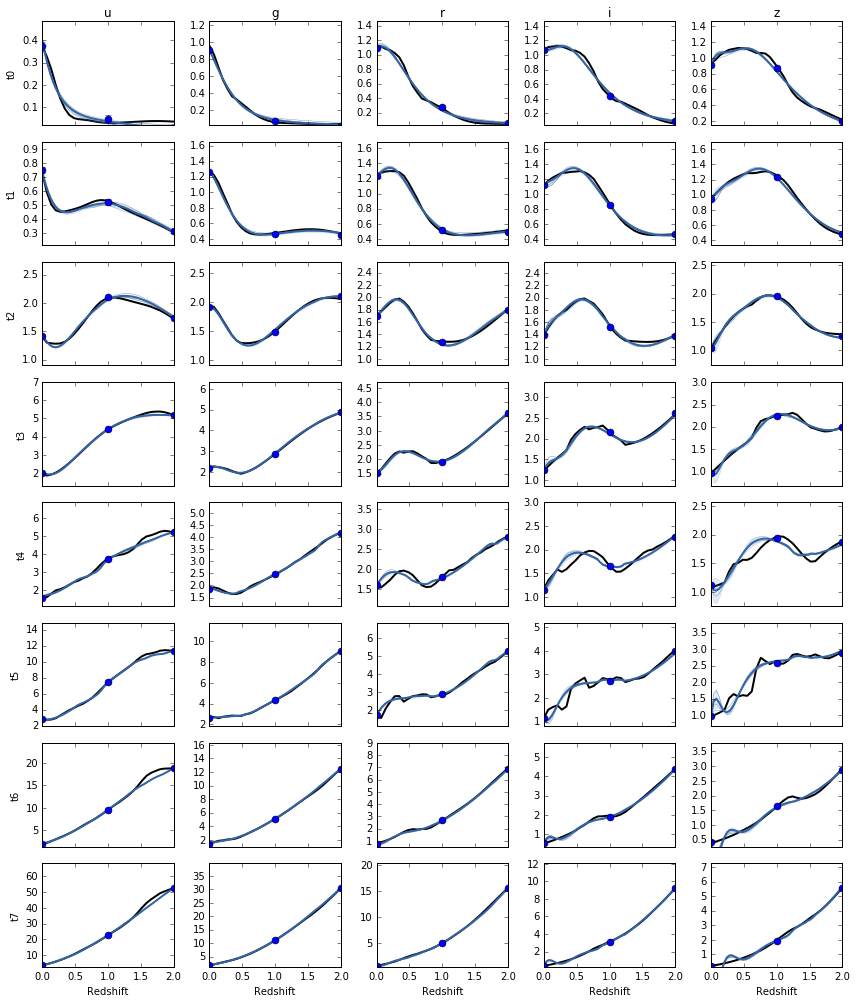

In [6]:
fig, axs = plt.subplots(nt, nf, figsize=(12, 14), sharex=True, sharey=False)
for t in typesUsed:
    for jf in range(nf):
        ind = np.logical_and(X[:,0].astype(int) == t, X[:,1].astype(int) == jf)  
        axs[t,jf].plot(redshiftGrid, f_mod[:,t,jf], ls='solid', lw=2, c='k')
        m_full.plot_f(fixed_inputs=[(0,t), (1,jf)], ax=axs[t,jf], legend=False, resolution=50, samples=3,
                plot_limits=[0, 2], plot_data=False, plot_inducing=False, plot_density=False, 
                      lower=16, upper=84)#, lower=2.5, upper=97.5)
        axs[t,jf].errorbar(X[ind,2], Y[ind], yerr=np.sqrt(Ynoise[ind]), fmt='o', markersize=7)
        if t == 0:
            axs[t,jf].set_title(ab_filters[jf])
        if t == nt-1:
            axs[t,jf].set_xlabel('Redshift')
        if jf == 0:
            axs[t,jf].set_ylabel('t'+str(t)) # template_names[t])
        axs[t,jf].set_ylim([0.7*np.min(f_mod[:,t,jf]), 1.3*np.max(f_mod[:,t,jf])])
fig.tight_layout()

In [7]:
Z = 1*X
Xb = 1*X
#Xb[:,0] = np.random.uniform(low=0, high=nt-1, size=X.shape[0])
xvariance = 1.1
Xb[:,0] += xvariance * np.random.randn(X.shape[0])
#Z[:,0] = np.random.uniform(low=0, high=nt-1, size=Z.shape[0])
#Z[:,1] = np.random.uniform(low=0, high=2, size=Z.shape[0])

m_sp = GPy.models.SparseGPLVM(Y[:,None], X.shape[1], X=Xb, kernel=k, num_inducing=Z.shape[0])
m_sp.kern.change_numlines(numlines)
m_sp.Z.fix(Z)
m_sp.likelihood.variance.fix(Ynoisevarianceval)
m_sp.kern.alpha_T.fix(m_full.kern.alpha_T)
m_sp.kern.alpha_L.fix(m_full.kern.alpha_L)
m_sp.kern.alpha_C.fix(m_full.kern.alpha_C)
m_sp.kern.var_T.fix(m_full.kern.var_T)
m_sp.kern.slope_T.fix(m_full.kern.slope_T)

print m_sp.parameter_names()
m_sp.optimize('bfgs', messages=True)

['latent space', 'inducing inputs', 'photoz.slope_T', 'photoz.var_T', 'photoz.alpha_C', 'photoz.alpha_L', 'photoz.alpha_T', 'Gaussian_noise.variance']


(-4.4000000000000004, 4.4000000000000004)

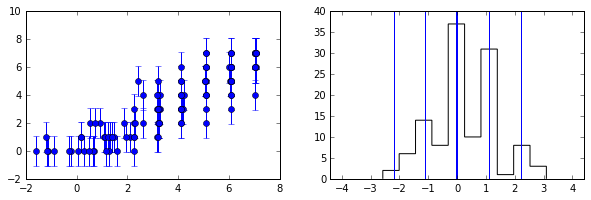

In [8]:
#print m_sp.X.values
#print m_sp.X.values[:5,0], X[:5,0]
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
axs[0].errorbar(m_sp.X.values[:,0], X[:,0], yerr=X[:,0]*0+xvariance, fmt="o")
axs[1].hist(m_sp.X.values[:,0]-X[:,0], histtype='step', color='k')
for v in [xvariance, -xvariance, 2*xvariance, -2*xvariance]:
    axs[1].axvline(v)
axs[1].axvline(0, lw=2)
v = np.max(np.abs(axs[1].get_xlim()))
axs[1].set_xlim([-1.1*v, v*1.1])

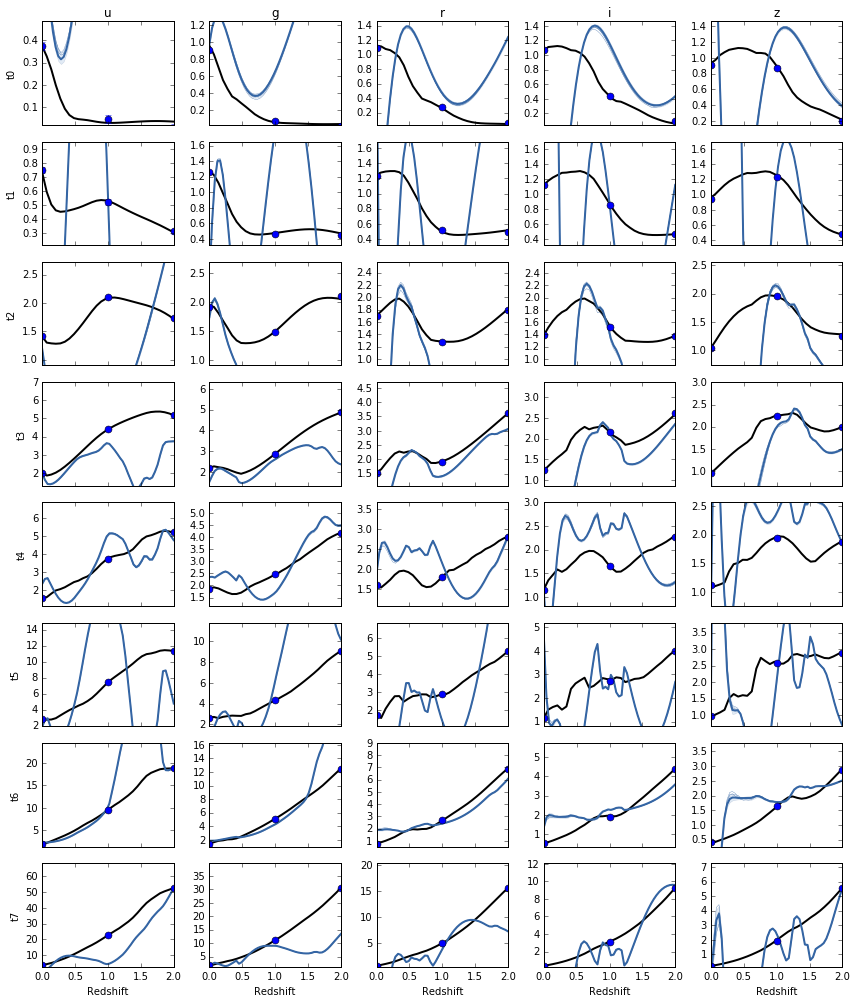

In [9]:
fig, axs = plt.subplots(nt, nf, figsize=(12, 14), sharex=True, sharey=False)
for t in typesUsed:
    for jf in range(nf):
        ind = np.logical_and(X[:,0].astype(int) == t, X[:,1].astype(int) == jf)  
        axs[t,jf].plot(redshiftGrid, f_mod[:,t,jf], ls='solid', lw=2, c='k')
        m_sp.plot_f(fixed_inputs=[(0,t), (1,jf)], ax=axs[t,jf], legend=False, resolution=50, samples=3,
                plot_limits=[0, 2], plot_data=False, plot_inducing=False, plot_density=False, 
                      lower=16, upper=84)#, lower=2.5, upper=97.5)
        axs[t,jf].errorbar(X[ind,2], Y[ind], yerr=np.sqrt(Ynoise[ind]), fmt='o', markersize=7)
        if t == 0:
            axs[t,jf].set_title(ab_filters[jf])
        if t == nt-1:
            axs[t,jf].set_xlabel('Redshift')
        if jf == 0:
            axs[t,jf].set_ylabel('t'+str(t)) # template_names[t])
        axs[t,jf].set_ylim([0.7*np.min(f_mod[:,t,jf]), 1.3*np.max(f_mod[:,t,jf])])
        
fig.tight_layout()


In [10]:
hmc = GPy.inference.mcmc.HMC(m_sp, stepsize=1e-4)
s = hmc.sample(num_samples=10) 

[ 0.  1.  2.  3.]
[ 0.67938381 -0.21322915  1.29259858  1.60347294]
[  0.00000000e+00   5.55111512e-17   0.00000000e+00   2.22044605e-16]


(array([  2.,   6.,  14.,   8.,  37.,  10.,  31.,   1.,   8.,   3.]),
 array([-2.57855842, -2.01109053, -1.44362264, -0.87615475, -0.30868685,
         0.25878104,  0.82624893,  1.39371683,  1.96118472,  2.52865261,
         3.0961205 ]),
 <a list of 10 Patch objects>)

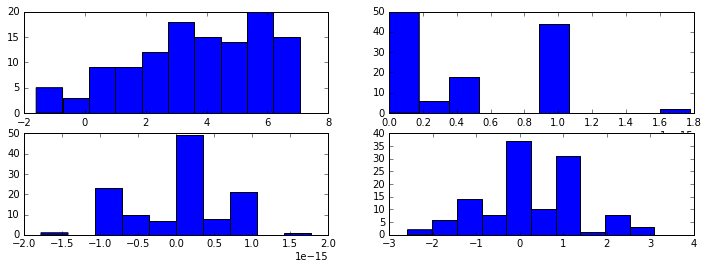

In [11]:
print X[:4,1]
print s[:,::3].mean(axis=0)[:4]
print s[:,::3].std(axis=0)[:4]
fig, axs = plt.subplots(2, 2, figsize=(12, 4))
axs = axs.ravel()
axs[0].hist(s[:,::3].mean(axis=0))
axs[1].hist(s[:,::3].std(axis=0))
axs[2].hist(m_sp.X[:,0]-s[:,::3].mean(axis=0))
axs[3].hist(m_sp.X[:,0]-X[:,0])

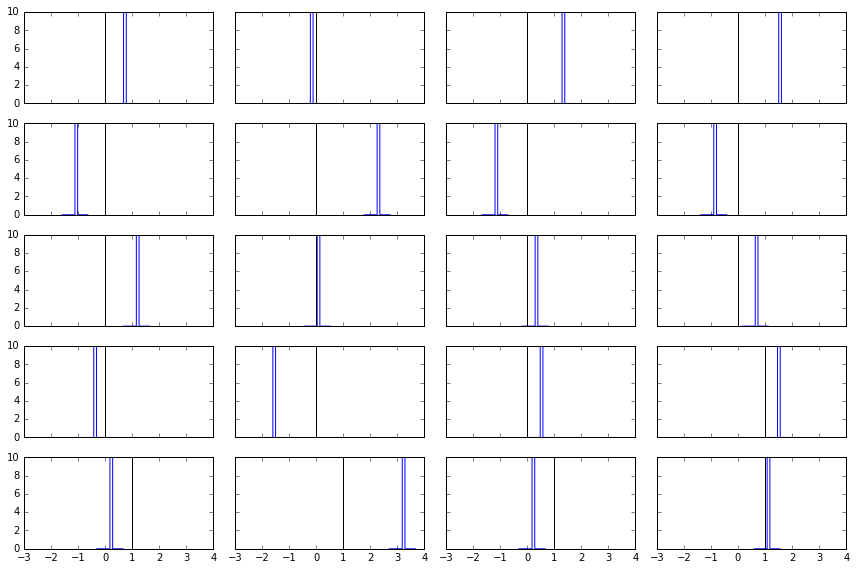

In [12]:
fig, axs = plt.subplots(5, 4, figsize=(12, 8), sharex=True, sharey=True)
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.hist(s[:,3*i], histtype='step')
    ax.axvline(X[i,0], color='k')
fig.tight_layout()

In [13]:
mh = GPy.inference.mcmc.Metropolis_Hastings(m_sp)
mh.sample(Ntotal=20, Nburn=10, Nthin=1) 

In [14]:
s = np.array(mh.chains[0])
print s[:,:].mean(axis=0)[:20]
print s[:,:].std(axis=0)[:20]
print X[:,0]

[ 0.67938381  0.          0.         -0.21322915  1.          0.
  1.29259858  2.          0.          1.60347294  3.          0.         -1.1167721
  4.          0.          2.2528108   0.          1.         -1.18423259
  1.        ]
[  0.00000000e+00   0.00000000e+00   0.00000000e+00   5.55111512e-17
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   2.22044605e-16   0.00000000e+00   0.00000000e+00
   2.22044605e-16   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   2.22044605e-16   0.00000000e+00]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  3.  3.  3.  3.  3.  3.  3.  3.  3.
  3.  3.  3.  3.  3.  3.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.
  4.  4.  4.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.
  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6. 